# IBM Data Science Certification: Applied Data Science Capstone

This notebook will be used for the Applied Data Science Capstone

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
 
1. <a href="#t1">Imports, Installs, Constants, & Functions</a>
    
1. <a href="#t2">Exploring Canadian Neighborhoods</a>
    
1. <a href="#t3">Profile of Venues (by Category) per Postal Code</a>
    
1. <a href="#t4">Cluster Postal Codes by Venu Categories (K-Means)</a>
    
</font>
</div>

In [158]:
# The code was removed by Watson Studio for sharing.

<a id='t1'></a>
## Imports, Installs, Constants, & Functions

Bring in some libraries for making things easier...like the [foursquare](https://pypi.org/project/foursquare/) library so we don't have to craft URLs by hand.

In [159]:
%%capture
# Get stuff installed
!pip install geocoder
!pip install foursquare
!pip install folium
!pip install wordcloud

import pandas as pd
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Geo-data
import geocoder
import foursquare
import folium # mapping

# Viz stuff
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)


# Watson Studio stuff
from project_lib import Project

# Others
import re
import html
import math

### Project connection
Ensure we can get saved off data so we're not calling a bunch of APIs all the time

In [160]:
project = Project(None, proj['id'], proj['token'])
print(f'This notebook is part of the {project.get_name()} project')

This notebook is part of the Coursera: Data Science Certification project


### Constants & Functions

Following are some constants and functions we'll use along the way

In [161]:
RADIUS=500
LIMIT=100
# Number of clusters
# previous lab used K=5, but I just think that's way too many...let's use 4 :)
K=4

client = foursquare.Foursquare(client_id=fsq['id'], client_secret=fsq['sec'], version=fsq['ver'])
VCOLUMNS = ['Postal code', 'n_lat', 'n_lon', 'venue', 'v_lat', 'v_lon', 'category']

def p_rc(df):
    print(f'{df.shape[0]} Rows, {df.shape[1]} Columns')

def geocode_it(postal_code=None):
    search = 'Toronto, Ontario'
    if postal_code != None:
        search = f'{postal_code}, {search}'
    g = geocoder.google(search, key=api_key)
    return g.latlng

TORONTO = geocode_it()


def rcsv2df(fname):
    try:
        df = pd.read_csv(project.get_file(fname))
        print(f'Reading in cached data from {fname}')
        return df
    except RuntimeError:
        print(f'{fname} not found, returning empty DataFrame')
        return pd.DataFrame()
    
def sdf2csv(fname, df):
    project.save_data(fname, df.to_csv(index=False), overwrite=True)
    

def getVenues(pcs, lats, lons, radius=RADIUS, limit=LIMIT):
    vlist = []
    for pc, lat, lon in zip(pcs, lats, lons):
        results = client.venues.search(params={'ll': f'{lat},{lon}', 'radius': radius, 'limit': limit})
        vlist.append([(pc, lat, lon, v['name'], v['location']['lat'], v['location']['lng'], v['categories'][0]['name']) for v in results['venues'] if len(v['categories']) > 0])
    
    venues = pd.DataFrame([item for venue in vlist for item in venue])
    venues.columns = VCOLUMNS
    return venues

def topXVenues(row, topX=10):
    row_sorted = row.sort_values(ascending=False)
    return row_sorted.index.values[0:topX]

def createLabel(pc, ns, cluster=None):
    clean = re.compile('<.*?>')
    ns_clean = re.sub(clean, '', ns)
    ns_list = ' '.join([f'<li>{n}</li> ' for n in html.escape(ns_clean, quote=True).split('/')])
    label = f'<h3>{pc}</h3>'
    if cluster is not None:
        label = label + f'<h4>Cluster: {cluster}</h4>'
    label = f'{label} <br><strong>Neighborhoods</strong><ul style="padding-left: 5px">{ns_list}</ul>'
    return label

def createMap(lats, lons, labels, colors, location=TORONTO, opacity=0.7, zoom=10):
    map = folium.Map(location=location, zoom_start=zoom)

    if not isinstance(colors, list):
        colors = [colors] * len(labels)
        
    for lat, lon, label, color in zip(lats, lons, labels, colors):
        html = folium.Html(label, script=True)
        popup = folium.Popup(html, parse_html=True, width=300, height=200)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=popup,
            color=colors,
            fill=True,
            fill_color=color,
            fill_opacity=opacity,
            parse_html=True).add_to(map)
        
    return map

<a id="t2"></a>
## Exploring Canadian Neighborhoods

1. Use the pandas [`read_html`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_html.html) function to read all the tables from the [List of postal codes of Canada: M](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). The first table (i.e. data frame) in the list will be the first (index = 0) element in the list.

1. After extracting the first table, get all the rows that have an *assigned* Borough (i.e. a Borough not equal to `Not assigned`).

1. According to the lab, there could be a postal code listed multiple times and that the neighborhood values should be combined in a comma separated list. *However*, it appears that the table has been updated and the neighborhoods are listed with `/` as a separator. Let's check...

1. I'll just stick with the `/` separator since it seems to be a unique character in the list. I'm assuming that the `Garden District, Ryerson` entry is actually a single place and not two places. Especially since the Garden District is where Ryerson University is located. 

1. Use the [geocoder library](https://geocoder.readthedocs.io/) to get the latitude and longitude of all the postal codes. **NOTE:** This requires a google API key. 

1. Lastly, let's see where these postal codes fall on a map using [folium](https://python-visualization.github.io/folium/index.html). **NOTE**: I'm using the latest version, other labs use 0.5.0.

In [162]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
postal_codes_raw = rcsv2df('postal_codes_raw.csv')

if (postal_codes_raw.empty):
    print(f'Getting data from {url}')
    tables = pd.read_html(url)
    postal_codes_raw = tables[0]
    sdf2csv('postal_codes_raw.csv', postal_codes_raw)

pcs = postal_codes_raw[postal_codes_raw['Borough'] != 'Not assigned'].reset_index(drop=True)
grps = pcs.groupby('Postal code').count()
print(f"Checking for any postal code listed more than once: {len(grps[grps['Borough'] > 1])}")


Reading in cached data from postal_codes_raw.csv
Checking for any postal code listed more than once: 0



Let's take a look at the resulting data frame:

In [163]:
p_rc(pcs)
pcs.head()

103 Rows, 3 Columns


,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


### GeoCode It

Add Latitude and Longitude to the dataframe. First just add the coordinates as a list (that's what google provides back). Then split those values out to latitude (`lat`) and longitude (`lon`).

In [164]:
pcs_geo = rcsv2df('pcs_geo.csv')

if (pcs_geo.empty):
    print('Getting Lat/Lon data...')
    pcs['LatLon'] = pcs.apply({'Postal code': lambda code: geocode_it(code)})
    pcs[['lat', 'lon']] = pd.DataFrame(pcs['LatLon'].tolist(), index=pcs.index)
    sdf2csv('pcs_geo.csv', pcs)
else:
    pcs = pcs_geo

Reading in cached data from pcs_geo.csv


In [165]:
pcs.head(10)

,Postal code,Borough,Neighborhood,LatLon,lat,lon
0,M3A,North York,Parkwoods,"[43.7532586, -79.3296565]",43.753259,-79.329656
1,M4A,North York,Victoria Village,"[43.72588229999999, -79.3155716]",43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,"[43.6542599, -79.36063589999999]",43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,"[43.718518, -79.4647633]",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,"[43.6623015, -79.3894938]",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,"[43.6678556, -79.5322424]",43.667856,-79.532242
6,M1B,Scarborough,Malvern / Rouge,"[43.8066863, -79.1943534]",43.806686,-79.194353
7,M3B,North York,Don Mills,"[43.7459058, -79.352188]",43.745906,-79.352188
8,M4B,East York,Parkview Hill / Woodbine Gardens,"[43.7063972, -79.30993699999999]",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson","[43.6571618, -79.3789371]",43.657162,-79.378937


### Map It
Let's take a look at where these postal codes fall

In [166]:
labels = [createLabel(row.loc['Postal code'], row['Neighborhood']) for _, row in pcs[['Postal code', 'Neighborhood']].iterrows()]

map = createMap(pcs['lat'], pcs['lon'], labels, colors='blue') 
map

<a href="t3"></a>
## Profile of Venues (by Category) per Postal Code

Now we will retrieve a list of venues (and venue categories) using the [foursquare library](https://github.com/mLewisLogic/foursquare) for each postal code. We'll use the one-hot encoding technique to get a list of venue categories per postal code. Then take the mean of that by grouping on postal code to get the frequency for what categories show up the most per postal code. That will be our input into K-Means.

1. Get a list of venues and the venue's category per postal code via Foursquare (using the postal code for this since neighborhood in this case can be ambiguous.

1. Build a DataFrame of dummy values for all the categories. Basically turn each category into a column and set the count to either 1 or 0 (using the `pd.get_dummies` function)

1. Add back the neighborhood to the new data frame and fix the column ordering

1. Build a cross-tab between postal code and category that has the frequency (e.g. mean) of the count of categories.

1. Take a look at the top 10 venues per postal code (just to get a rough idea).

In [167]:
venue_list = rcsv2df('venue_list.csv')

if venue_list.empty:
    print(f'Getting venue data...')
    venue_list = getVenues(pcs=pcs['Postal code'], lats=pcs['lat'], lons=pcs['lon'])
    sdf2csv('venue_list.csv', venue_list)

Reading in cached data from venue_list.csv


In [168]:
print(venue_list.shape)
venue_list.head()

(8779, 7)


,Postal code,n_lat,n_lon,venue,v_lat,v_lon,category
0,M3A,43.753259,-79.329656,TTC stop #8380,43.752672,-79.326351,Bus Stop
1,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,M3A,43.753259,-79.329656,GTA Restoration | Emergency Water Damage Plumb...,43.753567,-79.351308,Construction & Landscaping
3,M3A,43.753259,-79.329656,Joey,43.753441,-79.321640,Burger Joint
4,M3A,43.753259,-79.329656,Yorkmills Wellness & Spa,43.756800,-79.325346,Spa


In [169]:
venues_oh = pd.get_dummies(venue_list[['category']], prefix='', prefix_sep='')
venues_oh['Postal code'] = venue_list['Postal code']

# I suppose we can re-arrange the columns...
venues_oh = venues_oh[[venues_oh.columns[-1]] + list(venues_oh.columns[:-1])]
p_rc(venues_oh)
cat_no = len(venue_list['category'].unique())
print(f'There are {cat_no} unique categories')
venues_oh.head()


8779 Rows, 509 Columns
There are 508 unique categories


,Postal code,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Waste Facility,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M3A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Cross-Tab of means

In [170]:
venues_counts = venues_oh.groupby('Postal code').sum().reset_index()
venues_means = venues_oh.groupby('Postal code').mean().reset_index()
venues_means.head()

,Postal code,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Waste Facility,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.011111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.011111
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.011364,0.0,0.0,...,0.0,0.0,0.0,0.0,0.011364,0.0,0.0,0.011364,0.0,0.000000
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


### Examine Top Venues per Postal Code

We can collect the top venues per postal code (in this case the top 10) to take a cursory glance at what types of venues each postal code has. 

In [171]:
topX = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal code']
for ind in np.arange(topX):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Postal code'] = venues_means['Postal code']

for ind in np.arange(venues_means.shape[0]):
    srow = topXVenues(venues_means.iloc[ind, 1:], topX)
    top_venues.iloc[ind, 1:] = topXVenues(venues_means.iloc[ind, 1:], topX)

top_venues

,Postal code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Office,Automotive Shop,Factory,Coffee Shop,Building,Medical Center,Dentist's Office,Doctor's Office,Restaurant,Convenience Store
1,M1C,Automotive Shop,Office,Medical Center,Park,General Entertainment,Nail Salon,Salon / Barbershop,Breakfast Spot,Bar,Miscellaneous Shop
2,M1E,Residential Building (Apartment / Condo),Electronics Store,Church,Restaurant,Salon / Barbershop,Building,School,Medical Center,Thrift / Vintage Store,Bus Line
3,M1G,Cosmetics Shop,Pizza Place,Residential Building (Apartment / Condo),Salon / Barbershop,Coffee Shop,School,Building,Pharmacy,Indian Restaurant,Convenience Store
4,M1H,Bakery,Medical Center,Building,Doctor's Office,Residential Building (Apartment / Condo),Automotive Shop,Caribbean Restaurant,Pool,Pharmacy,Office
5,M1J,Residential Building (Apartment / Condo),Automotive Shop,Building,Pizza Place,Convenience Store,Gym / Fitness Center,Church,Salon / Barbershop,Gas Station,Ice Cream Shop
6,M1K,Residential Building (Apartment / Condo),Coffee Shop,Pharmacy,Office,School,Chinese Restaurant,Indian Restaurant,Salon / Barbershop,Church,Discount Store
7,M1L,Bus Line,Park,Parking,Automotive Shop,Residential Building (Apartment / Condo),Convenience Store,Office,Diner,Ice Cream Shop,Doctor's Office
8,M1M,Pizza Place,Office,Residential Building (Apartment / Condo),Laundry Service,Convenience Store,School,Salon / Barbershop,Gym / Fitness Center,Bar,Dentist's Office
9,M1N,Park,General Entertainment,Office,Indian Restaurant,Church,Bar,Thai Restaurant,Dessert Shop,Gas Station,Student Center


<a href="t4"></a>
## Cluster Postal Codes by Venu Categories (K-Means)

In [172]:
scores = venues_means.drop('Postal code', 1)
kmeans = KMeans(n_clusters=K, random_state=0).fit(scores)
top_venues.insert(0, 'Cluster', kmeans.labels_)

### Merge Cluster Data
Merge the cluster data from the top venues into the postal code table (pcs)

In [173]:
pcs_clusters = pcs
pcs_clusters = pcs_clusters.join(top_venues.set_index('Postal code'), on='Postal code')
p_rc(pcs_clusters)
pcs_clusters

103 Rows, 17 Columns


,Postal code,Borough,Neighborhood,LatLon,lat,lon,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,"[43.7532586, -79.3296565]",43.753259,-79.329656,2,Residential Building (Apartment / Condo),Bus Stop,Park,Elementary School,Office,School,Sandwich Place,Pool,Church,Other Nightlife
1,M4A,North York,Victoria Village,"[43.72588229999999, -79.3155716]",43.725882,-79.315572,2,Residential Building (Apartment / Condo),Automotive Shop,Office,Bank,Park,Building,Miscellaneous Shop,Government Building,Food,Bus Stop
2,M5A,Downtown Toronto,Regent Park / Harbourfront,"[43.6542599, -79.36063589999999]",43.654260,-79.360636,0,Office,Automotive Shop,Furniture / Home Store,Art Gallery,Italian Restaurant,Park,Auto Dealership,Coffee Shop,Building,Food Truck
3,M6A,North York,Lawrence Manor / Lawrence Heights,"[43.718518, -79.4647633]",43.718518,-79.464763,0,Clothing Store,Furniture / Home Store,Office,Design Studio,Women's Store,Miscellaneous Shop,Accessories Store,Athletics & Sports,Arcade,Boutique
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,"[43.6623015, -79.3894938]",43.662301,-79.389494,0,Government Building,Medical Center,Building,Restaurant,Capitol Building,Office,Medical Lab,Doctor's Office,College Library,Thai Restaurant
5,M9A,Etobicoke,Islington Avenue,"[43.6678556, -79.5322424]",43.667856,-79.532242,1,Bus Line,Park,Pharmacy,School,Residential Building (Apartment / Condo),Office,Factory,Candy Store,Bank,Cupcake Shop
6,M1B,Scarborough,Malvern / Rouge,"[43.8066863, -79.1943534]",43.806686,-79.194353,0,Office,Automotive Shop,Factory,Coffee Shop,Building,Medical Center,Dentist's Office,Doctor's Office,Restaurant,Convenience Store
7,M3B,North York,Don Mills,"[43.7459058, -79.352188]",43.745906,-79.352188,3,Office,Building,Medical Center,School,Doctor's Office,General Entertainment,Tech Startup,Sandwich Place,Conference Room,Athletics & Sports
8,M4B,East York,Parkview Hill / Woodbine Gardens,"[43.7063972, -79.30993699999999]",43.706397,-79.309937,0,Bus Stop,Building,Office,Dentist's Office,Fast Food Restaurant,Convenience Store,Bank,Café,Bus Line,Residential Building (Apartment / Condo)
9,M5B,Downtown Toronto,"Garden District, Ryerson","[43.6571618, -79.3789371]",43.657162,-79.378937,0,College Lab,College Administrative Building,University,College Arts Building,General College & University,College Classroom,Coffee Shop,Student Center,Parking,College Academic Building


In [174]:
# labels
labels = [createLabel(row.loc['Postal code'], row.loc['Neighborhood'], row.loc['Cluster']) for _, row in pcs_clusters[['Postal code', 'Neighborhood', 'Cluster']].iterrows()]

# set color scheme for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = cm.tab10(np.arange(K))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_clusters = createMap(pcs_clusters['lat'], pcs_clusters['lon'], labels, colors=[rainbow[c - 1] for c in pcs_clusters['Cluster']])    
       
map_clusters

### Clusters' Makeup
Let's look at what the clusters are actually made up of. We can utilize the fequencies we created ealier. We can group by the cluster to get all the venues for that cluster then sum up all the frequencies for the categories. This will produce a dictionary where the keys are the categories and the values are the frequencies. Then we can feed that to the word cloud generator and see the major makeup of each cluster.

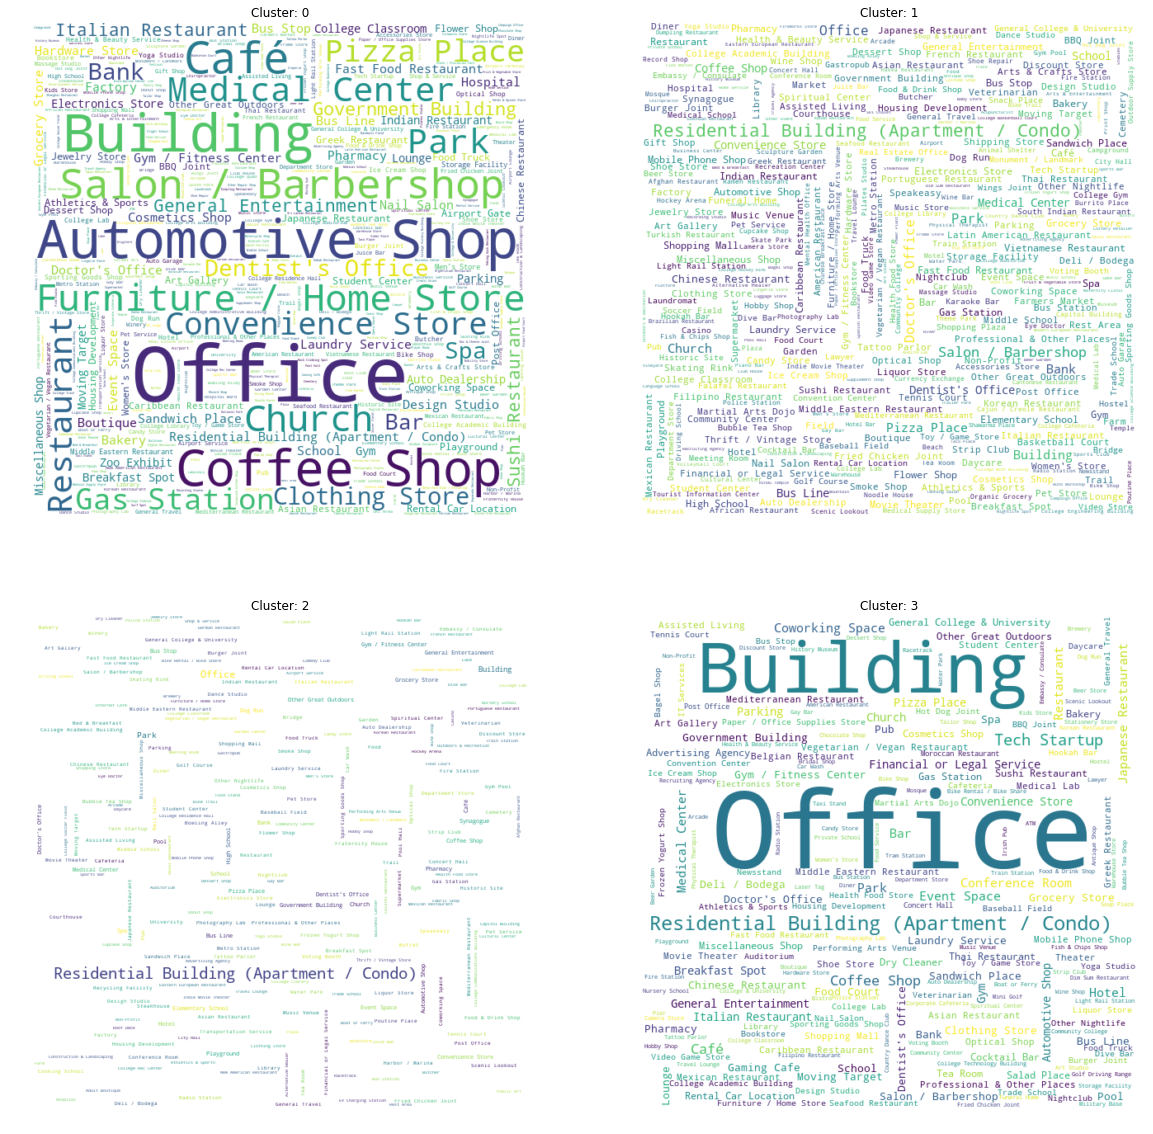

In [179]:
clusters = []
for c in range(K):
    # Get all the postal codes for a given cluster
    pcodes = pcs_clusters[pcs_clusters['Cluster'] == c]['Postal code']
    
    # get all the frequency scores for that particular cluster by the postal codes we just found
    # strip off the postal code and take the sum...this gives us a series
    scores = venues_means[venues_means['Postal code'].isin(pcodes)].iloc[:, 1:].sum().dropna()
    
    # get rid of the zeros
    scores = scores[scores > 0.0]
    # turn the scores series into a dictionary for wordcloud and append it to clusters
    clusters.append(dict(scores))
    

fig, axs = plt.subplots(math.ceil(K/2),2, figsize=(20,20))

for c, ax in zip(range(K), axs.flatten()):
    wc = WordCloud(
        background_color='white',
        max_words=2000,
        stopwords=STOPWORDS,
        height=600,
        width=600
    )

    wc.generate_from_frequencies(clusters[c])
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Cluster: {c}')

for ax in axs.flatten():
    ax.axis("off")

Welp, that's disappointing. I was hoping that the word clouds would really show off more distinction within the clusters. At any rate, I liked the idea so I thought I would try it. 